# DSPM HW#3

Name: Sudheeshna Sampath

Andrew ID: sudheess

# PART 1 - EDA

In [1]:
#load necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import nltk
import spacy
import re
from operator import itemgetter
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

In [2]:
#read input file
df_full = pd.read_csv("C:\\Users\\sudhe\\Desktop\\Spring '22\\DSPM\\HW3\\Twitter-sentiment-self-drive-DFE.csv")

In [3]:
#Drop unnecessary columns
df = df_full.drop(['_unit_state','sentiment_gold','sentiment_gold_reason'],axis=1)

In [4]:
#Get data summary
df.describe()

,_unit_id,_trusted_judgments,sentiment:confidence,our_id
count,7.156000e+03,7156.000000,7156.000000,7156.000000
mean,7.243474e+08,5.834405,0.774654,3609.930548
std,2.506742e+05,11.144930,0.205363,2140.401611
min,7.242270e+08,1.000000,0.248000,1.000000
25%,7.243229e+08,3.000000,0.630600,1789.750000
50%,7.243247e+08,4.000000,0.753100,3578.500000
75%,7.243265e+08,8.000000,1.000000,5367.250000
max,7.269423e+08,241.000000,1.000000,10077.000000


In [5]:
#Remove outliers in _trusted_judgments_column
df= df[np.abs(df['_trusted_judgments']-df['_trusted_judgments'].mean())<=(3*df['_trusted_judgments'].std())] 

#Remove not_relevant sentiments
df = df[df['sentiment']!='not_relevant']

In [6]:
#Find number of missing values in the data
miss_val = df.isnull().sum()
print("Column         # Missing values")
for key,value in miss_val.iteritems():
    if(value>0):
        print(key,":",value)

Column         # Missing values
_last_judgment_at : 1


In [7]:
#remove rows with missing _last_judgment_at 
df = df[df['_last_judgment_at'].isna()==False]

<AxesSubplot:xlabel='sentiment', ylabel='count'>

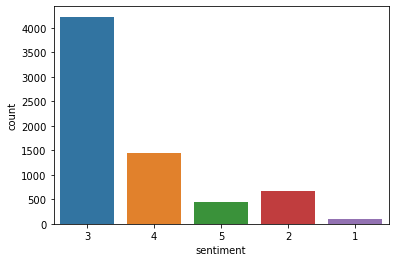

In [8]:
#Plot frequency of each sentiment
sns.countplot(x='sentiment', data=df)

The above graph shows that the dataset is imabalanced. The data has many samples of Sentiment 3 and very little samples related to sentiments 1,2 &5. This can cause incorrect predictions and low accuracy in these low sample sentiments

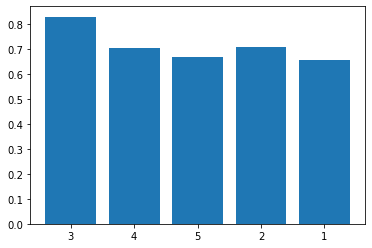

In [9]:
#plot sentiment confidence with respect to each sentiment
df['avg_sentiment_confidence'] = df.groupby(['sentiment'])['sentiment:confidence'].transform('mean')
plt.bar(df['sentiment'],df['avg_sentiment_confidence'])
plt.show()

The weights associated seem to be evenly distributed.

In [10]:
#Get count of each sentiment w.r.t each judgment at
df['_last_judgment_at_date'] = pd.to_datetime(df['_last_judgment_at'])
df['_last_judgment_at_date'] = df['_last_judgment_at_date'].values.astype('M8[D]')
df['_last_judgment_at_date'] = df['_last_judgment_at_date'].astype(str)

<Figure size 864x720 with 0 Axes>

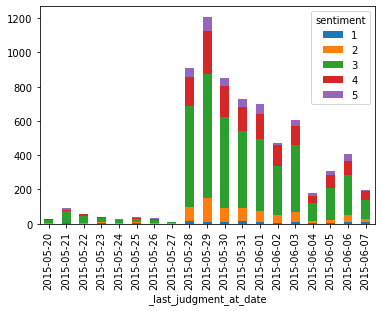

In [11]:
plt.figure(figsize=(12, 10))
df.groupby(['_last_judgment_at_date', 'sentiment']).size().unstack().plot(kind='bar', stacked=True)
plt.show()

Insights:

From our EDA, we see that the main problem with the dataset is imbalanaced data. To perform sentiment analysis, having lesser samples of certain sentiments can lead to inaccurate predictions and lesser accuracy in the sentiments with less samples. We can deal with this by oversampling our data to balance our dataset.

# PART 2 - Text Processing 

In [12]:
#load nlp package for text processing
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

In [13]:
#get tokenized text by removing stop words, urls and unnecessary punctions. 
#Stemming and lemmatization is performed to get required words from the text
def tokenize_text(text):
    tokenized_words = []
    split_text  = re.split('\s', text)
    for splt in split_text:
        parsed_text = nlp(splt)
        if (parsed_text.text not in tokenized_words):
                for t in parsed_text:
                    if((re.match('[A-Za-z0-9]',t.lemma_)) and not (re.match('http\S+',t.lemma_))):
                        if(t.lemma_ not in stopwords.words("english")):
                            word=stemmer.stem(parsed_text.text.lower().strip())
                            word = re.sub('[#.()-,]*','',word)
                            tokenized_words.append(word)      
    return tokenized_words

df['token_text'] = df['text'].apply(lambda x: tokenize_text(x))

In [14]:
df['token_text'] 

11      [audi, first, carmak, get, licens, nevada, dmv...
12      [audi, say, first, car, manufactur, world, get...
13      [future!, buy, one, audi, readi, test, autonom...
14      [audi, test, drive, driverless, car, tampa, to...
15      [audi, first, automak, california, test, self-...
                              ...                        
7083    [nvidia, drive, px, develop, platform, self-dr...
7084    [elon, musk, believ, self, drive, car, 50mph, ...
7085    [gtc2015, ceo, elon, musk, ceo, huang, discuss...
7086    [self, drive, bmw, also, drift, equal, good, p...
7088    [new, tesla, autopilot, read, speed, limit, si...
Name: token_text, Length: 6879, dtype: object

In [15]:
#get list of all tokens
token_words=[]
for i,r in df.iterrows():
    for x in r['token_text']:
            token_words.append(x)

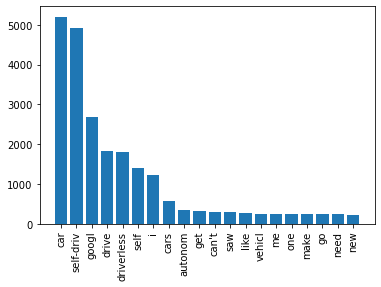

In [16]:
#find frequency of each token and get the top 20 tokens
tokenCounter= Counter()
for i,r in enumerate(token_words):
    tokenCounter[r]+=1

text_tokens = sorted(tokenCounter.items(),reverse=True,key=itemgetter(1))

most_freq_tokens = text_tokens[:20]

mostFreqTokens = []
for i,r in enumerate(most_freq_tokens):
    if(r[0] not in mostFreqTokens):
        mostFreqTokens.append(r[0])

#Plot the most frequently used tokens 
plt.bar([x[0] for x in most_freq_tokens],[x[1] for x in most_freq_tokens])
plt.xticks(rotation = 90) 
plt.show()

In [17]:
#get adjectives, nouns, proper nouns
adjectiveCount = Counter()
nounCount =  Counter()
prnCount = Counter()
punctCount =  Counter()

for i,r in df.iterrows():
    split_text  = re.split('\s', r['text'])
    for splt in split_text:
        parsed_text = nlp(splt)
        for t in parsed_text:
            if(t.lemma_ not in stopwords.words("english")):
                word=stemmer.stem(parsed_text.text.lower().strip())
                word = re.sub('[#.()-,?]*','',word)
                if(t.pos_ =='ADJ'):
                    adjectiveCount[word]+=1
                if(t.pos_ == 'NOUN'):
                    nounCount[word]+=1
                if(t.pos_ == 'PROPN'):
                    prnCount[word]+=1
                if(t.pos_ == 'PUNCT'):
                    punctCount[word]+=1                

In [18]:
## Part of speech tagging
#Most common words 
print("Most Common word")
print("Adjectives: ", adjectiveCount.most_common(5))
print("Nouns: ", nounCount.most_common(5))
print("Pronouns: ", prnCount.most_common(5))
print("Punction based words: ", punctCount.most_common(5))

Most Common word
Adjectives:  [('autonom', 345), ('new', 227), ('cool', 87), ('good', 80), ('great', 77)]
Nouns:  [('car', 5519), ('self-driv', 2821), ('driverless', 1821), ('self', 1439), ('cars', 691)]
Pronouns:  [('googl', 2668), ('google̢��\x89�', 388), ('@googl', 216), ('̢��\x89\u06dd', 204), ('rt', 193)]
Punction based words:  [('self-driv', 2459), ('car', 726), ('cars', 700), ('-', 357), ('@', 268)]


The Top frequency words are common across all sentiments and would hinder our predictions by adding unnecessary features.
We will remove them in the following steps them to increase the computation speed and accuracy of our model. 

In [19]:
#Remove most frequently used tokens
def remove_freq_words(text):
    new_token_list = []
    for x in text:
        if x not in mostFreqTokens:
            new_token_list.append(x)
    return new_token_list

df['token_text'] = df['token_text'].apply(lambda x: remove_freq_words(x))

# PART 3 - SENTIMENT PREDICTION

In [20]:
X=df.token_text
y=df.sentiment

In [21]:
#Scaling data for standardization
vectorizer = TfidfVectorizer(preprocessor=' '.join, stop_words='english')
vectorized_X = vectorizer.fit_transform(X)

print(len(vectorizer.get_feature_names_out()))

8028


In [22]:
#Oversampling data
ros = RandomOverSampler(sampling_strategy='all')
X_resampled, y_resampled = ros.fit_resample(vectorized_X, y)

As seen in the EDA, our data is imabalanced. Oversampling our dataset to even out samples for each sentiment will give better accuracy in our model. After prediction we will compare the performance of oversampled data against our original data to see if oversampling improves accuracy.

In [23]:
#Split dataset to train and test
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled,test_size = 0.10, random_state =26105111)

In [24]:
#Finding best parameters for our model via Grid Search Cross Validation
from sklearn.tree import DecisionTreeClassifier

dct = DecisionTreeClassifier()
dt_param = {'criterion':['gini','entropy'],'max_depth':[4,8,12,15,20,30,40,50,70,90,120,150,180]}
dt_random = GridSearchCV(dct, dt_param, cv=5)
dt_parameters = dt_random.fit(X_train, y_train)
dt_parameters.best_params_

{'criterion': 'entropy', 'max_depth': 180}

In [25]:
#Fitting our train data to predict sentiment on our test data
dtcModel = DecisionTreeClassifier(criterion= 'entropy',max_depth=150)
dtc = dtcModel.fit(X_train, y_train)
y_pred = dtcModel.predict(X_test)

#Model Accuracy
print("Decision tree Model Accuracy (Resampled): " ,  round(accuracy_score(y_test,y_pred)*100,2),"%")

Decision tree Model Accuracy (Resampled):  76.62 %


In [26]:
#Comparing it against original (non-oversampled) data 

Xtrain, Xtest, ytrain, ytest = train_test_split(vectorized_X,y,test_size = 0.10, random_state =26105111)
dtc_org = dtcModel.fit(Xtrain, ytrain)
y_pred_org = dtcModel.predict(Xtest)

print("Decision tree Model Accuracy (Original): " ,  round(accuracy_score(ytest,y_pred_org)*100,2),"%")

Decision tree Model Accuracy (Original):  63.52 %


We can see that oversampling our imbalanced data  improves our model accuracy by  ~12%

In [27]:
#predict sentiment for all of tokenized text column and add it as column to the dataframe
df['predicted_sentiment'] =  dtcModel.fit(vectorized_X, y).predict(vectorized_X)

In [28]:
##get top words for each sentiment 

mostFreqSent1 = Counter();
mostFreqSent2 = Counter();
mostFreqSent3 = Counter();
mostFreqSent4 = Counter();
mostFreqSent5 = Counter();

for i,r in df.iterrows():
    if r['predicted_sentiment']=='1':
        for w in r['token_text']:
            mostFreqSent1[w]+=1
    if r['predicted_sentiment']=='2':
        for w in r['token_text']:
            mostFreqSent2[w]+=1
    if r['predicted_sentiment']=='3':
        for w in r['token_text']:
            mostFreqSent3[w]+=1
    if r['predicted_sentiment']=='4':
        for w in r['token_text']:
            mostFreqSent4[w]+=1
    if r['predicted_sentiment']=='5':
        for w in r['token_text']:
            mostFreqSent5[w]+=1

print("Top 5 words for: ")
print("Sentiment 1: ", mostFreqSent1.most_common(5))
print("Sentiment 2: ", mostFreqSent2.most_common(5))
print("Sentiment 3: ", mostFreqSent3.most_common(5))
print("Sentiment 4: ", mostFreqSent4.most_common(5))
print("Sentiment 5: ", mostFreqSent5.most_common(5))

Top 5 words for: 
Sentiment 1:  [('would', 12), ('think', 10), ('fuck', 9), ('peopl', 8), ('want', 8)]
Sentiment 2:  [('think', 35), ('driver', 31), ("don't", 29), ('want', 28), ('problem', 26)]
Sentiment 3:  [('road', 163), ('via', 152), ('test', 151), ('see', 149), ('uber', 147)]
Sentiment 4:  [('want', 69), ('wait', 62), ('cool', 58), ('driver', 58), ('would', 57)]
Sentiment 5:  [('wait', 40), ('want', 32), ('love', 24), ('come', 21), ('cool', 18)]


There are some common words like : think, would, want across all sentiments. These are common words used in most sentiments. They are not particulary stop words so was not removed in the text processing, but removing some of them may increase model accuracy

# PART 4 - MODEL PERFORMANCE ACROSS SENTIMENT

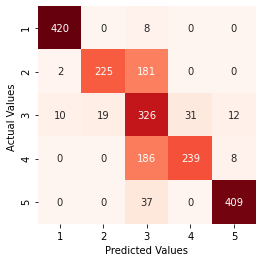

In [29]:
#Plotting confusion matrix to compare our predicted sentiment values against the actual sentiment values
from sklearn.metrics import confusion_matrix
dtc_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(dtc_matrix, square=True, annot=True, cmap='Reds', fmt='d', cbar=False)

ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['1','2','3','4','5'])
ax.yaxis.set_ticklabels(['1','2','3','4','5'])

plt.show()

In [30]:
#The model accuracy in predicting each sentiment
print("Prediciting accuracy:")

print("Sentiment 1 - ", round((dtc_matrix[0][0]/ dtc_matrix[0].sum())*100,2),"%")
print("Sentiment 2 - ", round((dtc_matrix[1][1]/ dtc_matrix[1].sum())*100,2),"%")
print("Sentiment 3 - ", round((dtc_matrix[2][2]/ dtc_matrix[2].sum())*100,2),"%")
print("Sentiment 4 - ", round((dtc_matrix[3][3]/ dtc_matrix[3].sum())*100,2),"%")
print("Sentiment 5 - ", round((dtc_matrix[4][4]/ dtc_matrix[4].sum())*100,2),"%")

Prediciting accuracy:
Sentiment 1 -  98.13 %
Sentiment 2 -  55.15 %
Sentiment 3 -  81.91 %
Sentiment 4 -  55.2 %
Sentiment 5 -  91.7 %


The model performs well on extreme sentiments - 1(Very negative) & 5 (Very positive). 
It also performs well on neutral sentiments (3). However it seems to have problem predicting 2 (slightly negative) & 4 (slightly positive) sentiments.

Ideas for improving model performance:
- Adding more data, especially for for sentiments 2&4 can improve prediction accuracy for those 2 sentiments. Increasing data overall can improve overall accuracy as well
- Feature selection: Selecting relevant features based on its importance can improve the model performance
- The accuracy in predicting these sentiments can be improved with better processing of the dataset. For instance, using a more exhaustive stop word list
- Using ensemble models like bagging & boosting can classify the data better giving us a better base level for improvement.